In [1]:
import os
import json
import imp
import numpy as np
import pandas as pd
import functions as utils
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from functools import partial
from concurrent.futures import ProcessPoolExecutor, Executor, as_completed

In [2]:
def read_data(path, filename):
    print(f'reading file = {os.path.join(path, filename)}')
    data = pd.read_csv(os.path.join(path, filename))
    data = data.rename(columns={'Unnamed: 0':'Id'})
    print(f'data shape = {data.shape}')
    types_info = pd.DataFrame(data.dtypes.value_counts(), columns=['columns_count'])
    print('types info about df columns: ')
    print(types_info)
    return data

In [3]:
# ls -la -h Datasets/GiveMeSomeCredit/

In [4]:
train_data = read_data(path='Datasets/GiveMeSomeCredit/', filename='cs-training.csv')
# test_data = read_data(path='Datasets/GiveMeSomeCredit/', filename='cs-test.csv')
# descript = pd.read_excel("Datasets/GiveMeSomeCredit/Data Dictionary.xls")
# sample_data = pd.read_csv("Datasets/GiveMeSomeCredit/sampleEntry.csv")

reading file = Datasets/GiveMeSomeCredit/cs-training.csv
data shape = (150000, 12)
types info about df columns: 
         columns_count
int64                8
float64              4


In [5]:
revolve_thresh = round(np.quantile(train_data.RevolvingUtilizationOfUnsecuredLines.values, q=[0.99])[0], 3)
# debtratio_thresh = round(np.quantile(train_data.DebtRatio.values, q=[0.9])[0], 3)
debtratio_thresh = 2.1
revolve_thresh

train_data = train_data[(train_data.RevolvingUtilizationOfUnsecuredLines < revolve_thresh) & 
                        (train_data.DebtRatio < debtratio_thresh)
                       ]
train_data.shape

(117910, 12)

In [6]:
train_data.fillna(int(train_data.MonthlyIncome.mean()), inplace=True)

In [7]:
train_data.fillna(0, inplace=True)
# test_data.fillna(0, inplace=True)

#ставим колонку Id как индекс клиента
train_data.set_index('Id', inplace=True)
# test_data.set_index('Id', inplace=True)

#сохраняем метку класса
train_label = train_data['SeriousDlqin2yrs'].copy()
train_data.drop('SeriousDlqin2yrs', axis=1, inplace=True)
#удаляем колонку класса из тестовых данных, так как она не несет никакой информации
# test_data.drop('SeriousDlqin2yrs', axis=1, inplace=True)

In [8]:
train_data['NumberOfDependents'] = train_data.NumberOfDependents.astype('int')
train_data['MonthlyIncome'] = train_data.MonthlyIncome.astype('int')

In [9]:
train_data.shape#, test_data.shape

(117910, 10)

In [10]:
float_cols = train_data.select_dtypes('float').columns
train_data.loc[:, float_cols] = train_data.loc[:, float_cols].round(2)
# train_data.head()

In [11]:
# float_cols = test_data.select_dtypes('float').columns
# test_data.loc[:, float_cols] = test_data.loc[:, float_cols].round(2)
# test_data.head()

In [12]:
transformed_train = utils.transform_to_description(train_data)
# transformed_test = transform_to_description(test_data)
# transformed_train.head(5)

In [13]:
transformed_train.shape#, transformed_test.shape

(117910, 10)

In [14]:
trainX, testX, trainY, testY = train_test_split(transformed_train, train_label, test_size=0.4)

In [15]:
valX, testX, valY, testY = train_test_split(testX, testY, test_size=0.5)

In [16]:
print(trainX.shape, valX.shape, testX.shape)
print(trainY.shape, valY.shape, testY.shape)

(70746, 10) (23582, 10) (23582, 10)
(70746,) (23582,) (23582,)


In [17]:
trainY.value_counts(normalize=True)

0    0.933494
1    0.066506
Name: SeriousDlqin2yrs, dtype: float64

In [18]:
valY.value_counts(normalize=True)

0    0.933381
1    0.066619
Name: SeriousDlqin2yrs, dtype: float64

In [19]:
testY.value_counts(normalize=True)

0    0.934399
1    0.065601
Name: SeriousDlqin2yrs, dtype: float64

In [14]:
# alpha = 0.005
# sample_ratio = 0.01
# num_iters = 100
# N_neg = train_label.value_counts().reset_index().iloc[0, 1]
# N_pos = train_label.value_counts().reset_index().iloc[1, 1]
# N_neg, N_pos

# train_pos = transformed_train.loc[train_label[train_label == 1].index]
# train_neg = transformed_train.loc[train_label[train_label == 0].index]

# classes_ratio_pos = train_pos.shape[0] / train_neg.shape[0]
# classes_ratio_neg = train_neg.shape[0] / train_pos.shape[0]
# classes_ratio_pos, classes_ratio_neg

### Mining step


    для положительного класса нас интересуют объекты отрицательного класса, 
    а для отрицательного - положительные
    Уже после определения объектов из другого класса, попадающие в признаковое представление семпла данных, будет приниматься решение
     о включение этого признакого представление в список гипотез представления(областей или интервальных представлений)
    

Что нужно посмотреть:

    1. Сравнение количества генерируемых гипотез в зависимости от критерия и области генерации выборки.
    (Возможно изобразить всего 4 варианта: старый подход - локальная или случайная выборка, новый подход - 
    локальная или случайная выборка)
    
    2. Сравнение генерируемых гипотез для старого и нового критерия в зависимости от ширины локальной области генерации
    (Возможно есть какая то оптимальная ширина окна)
    

In [293]:
def generate_hypothesis(iteration: int, obj: pd.Series, object_area: pd.Series, train_data: pd.DataFrame, 
                        other_data: pd.DataFrame, sample_size: int, hypothesis_criterion: str,
                        sample_type:str, verbose: bool, alpha: float):
        
        if iteration % 100 == 0:
            print(f'iteration: {iteration}')
        
        if sample_type == 'local' and object_area is None:
            print(f'Cannot generate sample from local area. Got None as local object area param!')
            raise NotImplementedError('Wrong params for local sampling!')
    
        if sample_type == 'random' and object_area is not None:
            print(f'got misleading params values. Got sample_type = None and local object area is not None')
            return NotImplementedError('Wrong params for random sampling!')

        sample = utils.generate_random_sample(train_data=train_data, sample_size=sample_size, d=object_area) 
        if sample is None:
            return None
        
        sample.append(obj)
        
        d = utils.get_similarity_sample_repr(sample)
        if verbose:
            print('got feature represantation for sample')
        
        d_other_objects = utils.is_included_in_repr(d, train_data=other_data)
        
        if verbose and d_other_objects is not None:
            print(f'got {d_other_objects.shape[0]} d_other_objects')
            print(f'thresh for hypothesis = {int(other_data.shape[0] * alpha)}')
        
        result_hypothesis = utils.check_criterion(
                        d=d, train_data=train_data, hypothesis_criterion=hypothesis_criterion, 
                        d_other_objects=d_other_objects, other_data=other_data, alpha=alpha)

        return result_hypothesis
        

def mining_step(test_obj: pd.Series, train_pos: pd.DataFrame, train_neg: pd.DataFrame, sample_ratio: float, 
                alpha: float, hypothesis_criterion: str, sample_type: str, trainx_min: pd.Series, 
                trainx_max:pd.Series, fraction: float = 0.25, num_iters: int = 1000, expanding_iters: int = 50, 
                mining_type: str = 'pos', verbose : bool = False, n_jobs : int = 4):
    """
    hypothesis_criterion: 'contr_class', если используем базовый критерий, 
                                когда смотрится пересечение с противоположным классом(старый критерий отбора гипотез)
                           'both_classes', когда интересует пересечение по обоим классам(новый критерий отбора гипотез)
                           
    sample_type: 'random', если берем произвольную выборку интервальных представлений
                 'local', если берем произвольную выборку из локальной области
    
    returns list of hypothesises
    """
    
    train_data = train_pos if mining_type == 'pos' else train_neg
    other_data = train_neg if mining_type == 'pos' else train_pos
    sample_size = int(train_data.shape[0] * sample_ratio)
    print('start generating hypothesises')
    
    if sample_type == 'local':
        print(f'start searching optimal local area')
        object_area = None
        itrs = 3
        while itrs > 0:
            object_area = utils.find_opt_local_area(obj=test_obj, train_data=train_data,
                                                    trainx_min=trainx_min, trainx_max=trainx_max, 
                                                    frac=fraction, expanding_iters=expanding_iters)
            if object_area is None:
                expanding_iters = 2 * expanding_iters
                itrs = itrs - 1
            else:
                break
        if object_area is None:
            sample_type = 'random'
    else:
        object_area = None
    
    print(f"""Use params: sample_type = {sample_type}""")
    if object_area is None:
        print('object area is None')
    else:
        print('object area is not None')
    print(f'num_iters = {num_iters}')
    print(f'expanding iters = {expanding_iters}')
    print(f"fraction = {fraction}")
    
    mining = partial(generate_hypothesis, obj=test_obj, object_area=object_area, train_data=train_data, 
                     other_data=other_data, sample_size=sample_size, hypothesis_criterion=hypothesis_criterion,
                     sample_type=sample_type, verbose=verbose, alpha=alpha)
    
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        hypothesises = executor.map(mining, range(num_iters))
        
    hypothesises = [res for res in hypothesises if res is not None]

    return hypothesises

In [76]:
train_pos = trainX.loc[trainY[trainY == 1].index]
train_neg = trainX.loc[trainY[trainY == 0].index]
train_pos.shape, train_neg.shape

((4705, 10), (66041, 10))

In [77]:
train_pos = train_pos.sample(n=1000, replace=False)
train_neg = train_neg.sample(n=1000, replace=False)
train_pos.shape, train_neg.shape

((1000, 10), (1000, 10))

In [78]:
trainx_min = train_data.min()
trainx_max = train_data.max()
test_sample = valX.sample(30)

In [79]:
utils = imp.reload(utils)

#### Исследования количества итераций, необходимых для достижения определенной доли объектов обучающей выборки

In [261]:
fractions = list(range(1, 23, 2))
fractions = [x/100 for x in fractions]
num_iters = 1000
print(fractions)

iterations_list_pos = {}
iterations_list_neg = {}

for frac in fractions:
    iterations_list_pos[frac] = []
    iterations_list_neg[frac] = []

[0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21]


In [82]:
for frac in fractions:
    print(f'frac = {frac}')
    for i, test_obj in test_sample.iterrows():
        d, num_iter = utils.find_opt_local_area(obj=test_obj, train_data=train_pos, trainx_min=trainx_min,
                                                trainx_max=trainx_max, frac=frac, num_iters=num_iters)
        
        iterations_list_pos[frac].append(num_iter)
        
iterations_list_pos_str = json.dumps(iterations_list_pos)

with open('iterations_list_pos.txt', 'w') as f:
    f.write(iterations_list_pos_str)

In [340]:
for frac in fractions:
    print(f'frac = {frac}')
    for i, test_obj in test_sample.iterrows():
        d, num_iter = utils.find_opt_local_area(obj=test_obj, train_data=train_neg, trainx_min=trainx_min,
                                                trainx_max=trainx_max, frac=frac, num_iters=num_iters)
        
        iterations_list_neg[frac].append(num_iter)
        
iterations_list_neg_str=json.dumps(iterations_list_neg)

with open('iterations_list_neg.txt', 'w') as f:
    f.write(iterations_list_neg_str)

In [132]:
with open('iterations_list_pos_result.txt', 'r') as f:
    iteration_list_pos_str = f.read()
iterations_list_pos = json.loads(iteration_list_pos_str)
print(iterations_list_pos)

with open('iterations_list_neg_result.txt', 'r') as f:
    iteration_list_neg_str = f.read()
iterations_list_neg = json.loads(iteration_list_neg_str)
print(iterations_list_neg)

{'0.01': [14, 14, 96, 16, 20, 12, 10, 14, 60, 14, 41, 17, 26, 15, 16, 14, 14, 17, 13, 13, 12, 11, 18, 36, 13, 8, 14, 19, 11, 17], '0.03': [18, 21, 97, 23, 26, 18, 15, 20, 79, 19, 58, 22, 32, 19, 20, 18, 18, 23, 18, 19, 16, 16, 23, 53, 21, 12, 18, 28, 18, 20], '0.05': [20, 25, 97, 27, 30, 21, 18, 25, 92, 22, 71, 25, 35, 23, 25, 21, 21, 25, 21, 23, 19, 18, 26, 63, 26, 14, 21, 31, 21, 23], '0.07': [22, 27, 97, 31, 33, 23, 19, 28, 102, 25, 82, 27, 38, 25, 27, 22, 24, 26, 24, 28, 23, 21, 32, 71, 30, 16, 24, 35, 25, 24], '0.09': [24, 28, 98, 32, 36, 25, 22, 31, 111, 27, 90, 27, 40, 27, 30, 24, 26, 29, 26, 29, 25, 23, 37, 76, 34, 18, 26, 38, 27, 26], '0.11': [25, 30, 98, 34, 38, 26, 24, 35, 116, 31, 95, 27, 44, 29, 32, 26, 28, 31, 28, 33, 27, 24, 43, 79, 39, 21, 27, 41, 30, 28], '0.13': [26, 32, 98, 36, 41, 28, 26, 39, 123, 33, 103, 27, 45, 31, 35, 27, 30, 32, 30, 35, 29, 26, 47, 83, 43, 23, 29, 45, 33, 29], '0.15': [29, 34, 98, 37, 44, 29, 28, 42, 128, 36, 107, 28, 47, 33, 36, 27, 32, 34, 32

In [133]:
for key, val in iterations_list_pos.items():
    iterations_list_pos[key] = np.mean(val)
    
iterations_list_pos = pd.DataFrame.from_dict(data=iterations_list_pos, orient='index', columns=['iters'])
iterations_list_pos.reset_index(drop=False, inplace=True)
iterations_list_pos.rename(columns={'index':'frac'}, inplace=True)

In [134]:
for key, val in iterations_list_neg.items():
    iterations_list_neg[key] = np.mean(val)

iterations_list_neg = pd.DataFrame.from_dict(data=iterations_list_neg, orient='index', columns=['iters'])
iterations_list_neg.reset_index(drop=False, inplace=True)
iterations_list_neg.rename(columns={'index':'frac'}, inplace=True)

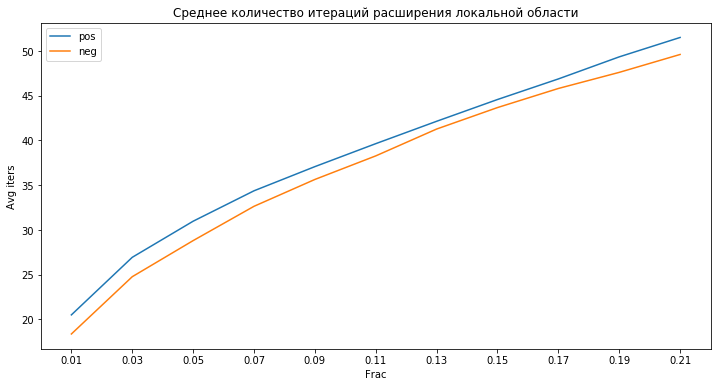

In [150]:
plt.figure(figsize=(12,6))
sns.lineplot(y='iters', x='frac', data=iterations_list_pos, label='pos')
sns.lineplot(y='iters', x='frac', data=iterations_list_neg, label='neg')
plt.ylabel('Avg iters')
plt.xlabel('Frac')
plt.title('Среднее количество итераций расширения локальной области')
plt.legend()
plt.savefig('images/AvgItersLocalExpanding.png')

    Измененный вариант отбора объектов, по которым будут искаться гипотезы
    Будем смотреть объекты обучающей выборки, которые находятся в локальной области тестового объекта
    На рисунке представлен график изменения объектов обучающей выборки для каждого класса. По оси Х представлена доля объектов из обучающей выборки, а по оси Y - количество итераций расширения локальной области, которое необходимо произвести, чтобы определенная доля объектов из выборки оказалась в локальной области объекта

**Исследование количества генерируемых гипотез в зависимости от набора параметров для нового подхода отбора гипотез**

*Сначала проверим построение старого подхода генерации гипотез*

In [294]:
alpha_params = [0.004]#, 0.002, 0.003, 0.004]
sample_ratio_params = [0.004]#, 0.002, 0.004, 0.006, 0.008, 0.01]

results_pos = {}
results_neg = {}
pos_hyps = []
neg_hyps = []

for alpha in alpha_params:
    results_pos[alpha] = {}
    results_neg[alpha] = {}
    
for alpha in alpha_params:
    for sample_ratio in sample_ratio_params:
        results_pos[alpha][sample_ratio] = []
        results_neg[alpha][sample_ratio] = []

In [295]:
params = {
    'train_pos': train_pos,
    'train_neg': train_neg,
    'num_iters': 300,
    'hypothesis_criterion': 'contr_class',
    'sample_type': 'random',
    'trainx_min': trainx_min,
    'trainx_max': trainx_max,
    'verbose': False,
    'n_jobs': 4
}

In [296]:
%%time
for alpha in alpha_params:
    for sample_ratio in sample_ratio_params:
        for i, obj in test_sample[4:5].iterrows():
            print(f"""using params: alpha = {alpha}, \n
            sample_ratio = {sample_ratio},\n
            num_iters = {params['num_iters']}""")
            pos_hyps = mining_step(test_obj=obj, sample_ratio=sample_ratio, alpha = alpha,
                                   mining_type='pos', **params)
            
            pos_hyps_shape = pd.DataFrame(pos_hyps).shape[0] if len(pos_hyps) > 0 else 0
            results_pos[alpha][sample_ratio].append(pos_hyps_shape)
            
            neg_hyps = mining_step(test_obj=obj, sample_ratio=sample_ratio, alpha = alpha,
                                   mining_type='neg', **params)
            
            neg_hyps_shape = pd.DataFrame(neg_hyps).shape[0] if len(neg_hyps) > 0 else 0
            results_neg[alpha][sample_ratio].append(neg_hyps_shape)

using params: alpha = 0.004, 

            sample_ratio = 0.004,

            num_iters = 300
start generating hypothesises
Use params: sample_type = random
object area is None
num_iters = 300
expanding iters = 50
fraction = 0.25
iteration: 0
iteration: 100
iteration: 200
start generating hypothesises
Use params: sample_type = random
object area is None
num_iters = 300
expanding iters = 50
fraction = 0.25
iteration: 0
iteration: 100
iteration: 200
CPU times: user 4.5 s, sys: 460 ms, total: 4.96 s
Wall time: 1min


**Новый подход генерации гипотез**

In [309]:
alpha_params = [2.0]#, 1.05, 1.1, 1.3, 1.5, 1.7, 2.0]
sample_ratio_params = [0.002]#, 0.002, 0.004, 0.006, 0.008, 0.01]

results_pos = {}
results_neg = {}
pos_hyps = []
neg_hyps = []

for alpha in alpha_params:
    results_pos[alpha] = {}
    results_neg[alpha] = {}
    
for alpha in alpha_params:
    for sample_ratio in sample_ratio_params:
        results_pos[alpha][sample_ratio] = []
        results_neg[alpha][sample_ratio] = []

In [310]:
print(results_pos)
print(results_neg)

{2.0: {0.002: []}}
{2.0: {0.002: []}}


In [313]:
params = {
    'train_pos': train_pos,
    'train_neg': train_neg,
    'num_iters': 200,
    'hypothesis_criterion': 'both_classes',
    'sample_type': 'local',
    'trainx_min': trainx_min,
    'trainx_max': trainx_max,
    'fraction': 0.17,
    'expanding_iters': 120, #максимальное количество итераций расширения
    'verbose': False,
    'n_jobs': 4
}

In [314]:
utils = imp.reload(utils)

In [315]:
%%time
for alpha in alpha_params:
    for sample_ratio in sample_ratio_params:
        for i, obj in test_sample[5:6].iterrows():
            print(f"""using params: alpha = {alpha}, \n
                sample_ratio = {sample_ratio}, \n
                num_iters = {params['num_iters']}""")
            pos_hyps = mining_step(test_obj=obj, sample_ratio=sample_ratio, alpha = alpha,
                                   mining_type='pos', **params)
            
            pos_hyps_shape = pd.DataFrame(pos_hyps).shape[0] if len(pos_hyps) > 0 else 0
            results_pos[alpha][sample_ratio].append(pos_hyps_shape)
            
            neg_hyps = mining_step(test_obj=obj, sample_ratio=sample_ratio, alpha = alpha,
                                   mining_type='neg',**params)
            
            neg_hyps_shape = pd.DataFrame(neg_hyps).shape[0] if len(neg_hyps) > 0 else 0
            results_neg[alpha][sample_ratio].append(neg_hyps_shape)

using params: alpha = 2.0, 

                sample_ratio = 0.002, 

                num_iters = 200
start generating hypothesises
start searching optimal local area
itr: 10
itr: 20
itr: 30
itr: 40
Use params: sample_type = local
object area is not None
num_iters = 200
expanding iters = 120
fraction = 0.17
iteration: 0
iteration: 100
start generating hypothesises
start searching optimal local area
itr: 10
itr: 20
itr: 30
Use params: sample_type = local
object area is not None
num_iters = 200
expanding iters = 120
fraction = 0.17
iteration: 0
iteration: 100
CPU times: user 22.1 s, sys: 873 ms, total: 22.9 s
Wall time: 2min 18s


**Оценивание модели, вычисление ROC AUC and Gini coefficient**

##### Проделаем для стандартного метода, который уже использовался

    Берем множество объеков(тестовое)
    Для каждого объекта считаем множество положительных и негативных гипотез
    Разница между количеством гипотез будет как раз скором, а знак этой разницы - классом

In [339]:
for i, test_obj in test_sample.iterrows():
    pos_hyps = mining_step(test_obj=test_obj, train_pos=train_pos, train_neg=train_neg, 
                            num_iters='',sample_ratio='', alpha = '',
                                   hypothesis_criterion='contr_class', sample_type='random',
                                   mining_type='pos', trainx_min=trainx_min, trainx_max=trainx_max,
                                    verbose=False, n_jobs=4
                        )
    neg_hyps = mining_step(test_obj=test_obj, train_pos=train_pos, train_neg=train_neg, 
                            num_iters='',sample_ratio='', alpha = '',
                                   hypothesis_criterion='contr_class', sample_type='random',
                                   mining_type='neg', trainx_min=trainx_min, trainx_max=trainx_max,
                           verbose=False, n_jobs=2
                        )
pos_hyps = pd.DataFrame(pos_hyps)
neg_hyps = pd.DataFrame(neg_hyps)

In [295]:
from time import sleep

In [213]:

sample_ratio=0.003
alpha = 0.004
hypothesis_criterion = 'both_classes'
sample_type = 'local'

In [260]:
params = {
    'train_pos': train_pos,
    'train_neg': train_neg,
    'num_iters': 150,
    'alpha':0.004,
    'sample_ratio':0.004,
    'hypothesis_criterion': 'both_classes',
    'sample_type': 'local',
    'trainx_min': trainx_min,
    'trainx_max': trainx_max,
    'fraction': 0.17,
    'num_iters': 200, #максимальное количество итераций расширения
    'verbose': False,
    'n_jobs': 4
}

In [249]:
def calculate_metric_for_obj(test_obj: pd.Series, **kwargs):
    
    
    pos_hyps = mining_step(test_obj=test_obj, mining_type='pos', **kwargs)
    pos_hyps = pd.DataFrame(pos_hyps)
    
    
    neg_hyps = mining_step(test_obj=test_obj, mining_type='neg', **kwargs)
    neg_hyps = pd.DataFrame(neg_hyps)
    
    
    diff = pos_hyps.shape[0] - neg_hyps.shape[0]
    label = None
    if diff > 0:
        label = 1
    elif diff < 0:
        label = 0
    else:
        label = -1
        
    return diff, label

In [250]:
def evaluate_model(test_sample: pd.DataFrame, **kwargs):
    
    results = {}
    
    print(f'using params: num_iters = {num_iterations}, sample_ratio = {sample_ratio}, alpha = {alpha}')
    
    for i, test_obj in test_sample.iterrows():
        diff, label = calculate_metric_for_obj(test_obj=test_obj, **kwargs)
        results[i] = (diff, label)
        
    return results

In [257]:
results = {}

In [258]:
utils=imp.reload(utils)

In [259]:
%%time
results = evaluate_model(test_sample=test_sample[9:12], **params)

using params: num_iters = 1000, sample_ratio = 0.003, alpha = 0.004
start generating hypothesises
start searching optimal local area
0.17 120
itr: 10
itr: 20
itr: 30
itr: 40
iteration: 0
iteration: 100
start generating hypothesises
start searching optimal local area
0.17 120
itr: 10
itr: 20
itr: 30
iteration: 0
iteration: 100
start generating hypothesises
start searching optimal local area
0.17 120
itr: 10
itr: 20
itr: 30
itr: 40
iteration: 0
iteration: 100
start generating hypothesises
start searching optimal local area
0.17 120
itr: 10
itr: 20
itr: 30
iteration: 0
iteration: 100
start generating hypothesises
start searching optimal local area
0.17 120
itr: 10
itr: 20
itr: 30
itr: 40
itr: 50
itr: 60
itr: 70
itr: 80
itr: 90
itr: 100
not enough iterations. try more iterations/ Current num_iters = 120
iteration: 0
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample

Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
iteration: 100
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local object area param!
Cannot generate sample from local area. Got None as local obj

NotImplementedError: Wrong params for local sampling!

In [207]:
results

{40388: (-21, 0), 2606: (-24, 0), 24092: (-32, 0)}

In [211]:
test_sample.loc[test_sample[9:12].index]

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
Id,,,,,,,,,,
40388,"(0.01, 0.01)","(28, 28)","(0, 0)","(0.07, 0.07)","(7083, 7083)","(7, 7)","(0, 0)","(0, 0)","(0, 0)","(1, 1)"
2606,"(0.25, 0.25)","(66, 66)","(0, 0)","(0.83, 0.83)","(4183, 4183)","(17, 17)","(0, 0)","(3, 3)","(0, 0)","(0, 0)"
24092,"(0.7, 0.7)","(29, 29)","(0, 0)","(0.81, 0.81)","(1000, 1000)","(5, 5)","(0, 0)","(0, 0)","(0, 0)","(0, 0)"


In [ ]:
vals

In [24]:
# %%time
# t = hypothesises_to_feat_matrix(pos_hyps=pos_hyps, neg_hyps=neg_hyps, trainX=train_pos.sample(1))

**Обучение, основанное на признаках, полученных из сгенерированных гипотез**

In [290]:
%%time
gen = transform_to_feature_matrix(pos_hyps=pos_hyps, neg_hyps=neg_hyps, trainX=trainX.sample(512))

CPU times: user 4.07 s, sys: 442 ms, total: 4.51 s
Wall time: 3min 47s


In [285]:
1.18, 1.25, 1.71, 2 range 1 4
3.95(8), 7.35(16), 29(64), 512

(1.18, 1.25, 1.71)

In [70]:
# %%time
# result = hypothesises_to_feat_matrix(pos_hyps=pos_hyps, neg_hyps=neg_hyps, trainX=trainX.sample(1000))

**Обучение композиции, основанное на гипотезах, считая их слабыми классификаторами(Бустинг)**

In [36]:
pos_hyps = pd.read_csv('hypothesises/test_pos_hyps.csv')
neg_hyps = pd.read_csv('hypothesises/test_neg_hyps.csv')
hyps = pd.concat([pos_hyps, neg_hyps])
hyps.reset_index(drop=True, inplace=True)

In [43]:
def hyps_boosting(hypothesises: pd.DataFrame, num_iterations):
    '''
    у гипотез есть индекс, просто число, от 0 до кол-ва гипотез, будем использовать его за id этой гипотезы
    '''
    
    ansamble = []
    weights = list(range(1, 11))
    weights = [w / 10 for w in weights]
    
    hyps_indices = list(hypothesises.index)
    
    ##допустим первую берем случайно(потом переделаем, чтоб брать осознанно)
    index = np.random.choice(hyps_indices, replace=False)
    h = hypothesises.loc[index]
    hyps_indices.remove(index)
    ansamble.append(h)
    
    #тут еще проверяется критерий того, что данный 
    while not hyps_indices and num_iterations > 0:
        
        index = np.random.choice(hyps_indices, replace=False)
        h = hypothesises.loc[index]
        
        
    
    return weights
    
    

In [42]:
hyps_boosting(hypothesises=hyps, num_iterations=10)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [83]:
inds = list(range(13))
inds

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [104]:
np.random.choice(inds)

5

In [62]:
# a = pd.Series({'feat1':(1,1), 'feat2':(0, 1.4), 'feat3':(3, 4)})
# b = pd.Series({'feat1':(1,2), 'feat2':(1, 1.4), 'feat3':(7, 7)})
# c = pd.Series({'feat1':(1,1), 'feat2':(0.8, 1.6), 'feat3':(3, 4)})
# d = pd.Series({'feat1':(2,3), 'feat2':(0, 1.4), 'feat3':(4, 6)})


# print(a.equals(b))
# print(a == b)

# test1 = pd.Series({'feat1':(1,3), 'feat2':(1, 3.4), 'feat3':(1, 1.9)})
# test2 = pd.Series({'feat1':(2,2.2), 'feat2':(2, 2.4), 'feat3':(3, 3.9)})
# test3 = pd.Series({'feat1':(3,3), 'feat2':(4, 4.4), 'feat3':(4, 4.9)})

g1 = pd.Series({'feat1':(1,1), 'feat2':(1.5, 1.5)})
g2 = pd.DataFrame({'feat1':(-1,-1), 'feat2':(0, 0)})
g3 = pd.Series({'feat1':(0.5,0.5), 'feat2':(1, 1)})

test1 = pd.Series({'feat1':(0.1, 1), 'feat2':(-0.5, 0)})
test2 = pd.DataFrame({'feat1':(-0.1, 1), 'feat2':(0.5, 0.8)})
tst = pd.Series({'feat1':(-1, 1), 'feat2':(0, 1.5)})

In [287]:
# for i,obj in sample.iterrows():
#     print(similarity(pd.DataFrame(d).T, obj))

In [286]:
# sample = pd.DataFrame([g1, g2, g3, test1, test2])
# sample

In [248]:
g1

feat1        (1, 1)
feat2    (1.5, 1.5)
dtype: object

In [95]:
type(d), type(sample)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [186]:
# is_included_in_repr(d, sample)

Тестовая функция провекри np.random.choice

In [40]:
def compute_stat(times, data):
    print(f"times = {times}")
    sample = np.random.RandomState().choice(data, replace=False, size=10)
    print(f"sample = {sample}")
    sample_sum = np.sum(sample)
    print(f"sample sum = {sample_sum}")
    return sample_sum

def run_computing(n_jobs=2):
    data = list(range(100))
    
    compute_func = partial(compute_stat, data=data)
    
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        results = executor.map(compute_func, list(range(26)))
    
    return results

In [284]:
# t = run_computing(n_jobs=6)